In [1]:
# -*- coding:utf8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
# 删除没用的字段
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

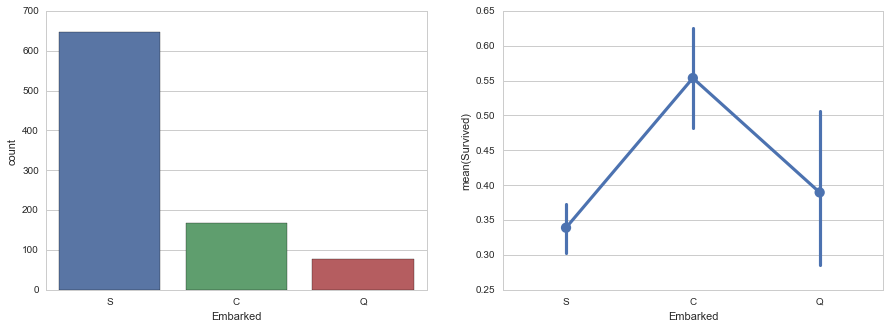

In [6]:
# Embarked
# 处理：由于就train_df有两个缺失值 就把缺失值填补为S(最多)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
train_df['Embarked'].fillna( train_df['Embarked'].dropna().mode()[0], inplace=True )

# 分布
sns.countplot(x='Embarked', data=train_df, ax=ax1)
# 集中情况
sns.pointplot(x='Embarked', y='Survived', data=train_df, ax=ax2)

# 设置哑变量
train_df.join( pd.get_dummies(train_df['Embarked']).drop(['S'], axis=1) )
test_df.join( pd.get_dummies(test_df['Embarked']).drop(['S'], axis=1) )
train_df.drop(['Embarked'], axis=1, inplace=True)
test_df.drop(['Embarked'], axis=1, inplace=True)


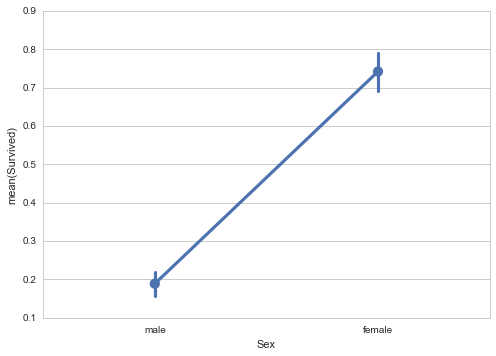

In [7]:
# Sex
# 处理：映射到01
sns.pointplot(x='Sex', y='Survived', data=train_df)

train_df['Gender'] = train_df['Sex'].map( {'female':0, 'male':1} ).astype(int)
test_df['Gender'] = test_df['Sex'].map( {'female':0, 'male':1} ).astype(int)
train_df.drop(['Sex'], axis=1, inplace=True)
test_df.drop(['Sex'], axis=1, inplace=True)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


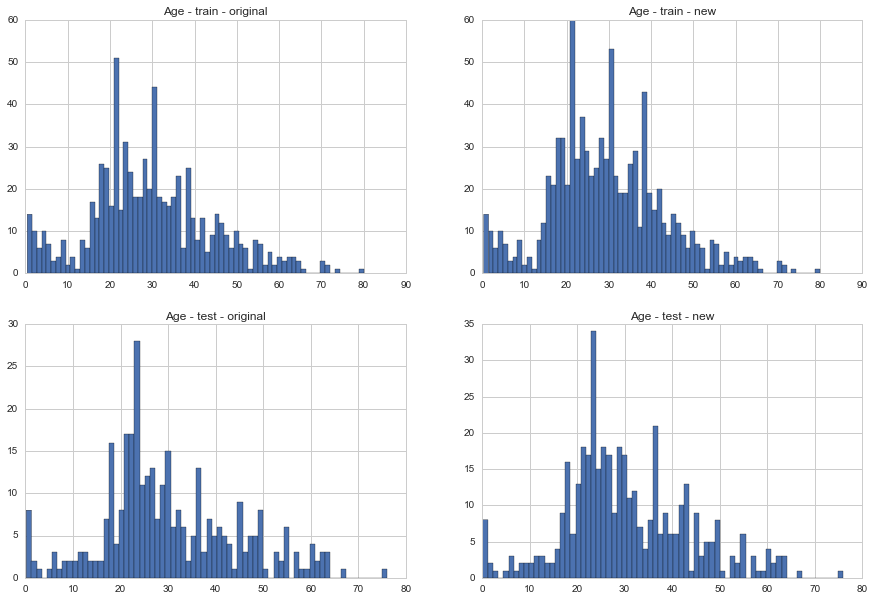

In [8]:
# Age
# 处理：填补(mean-std) between (mean+std)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
ax1.set_title('Age - train - original')
ax2.set_title('Age - train - new')
ax3.set_title('Age - test - original')
ax4.set_title('Age - test - new')

# 处理前
train_df['Age'].hist(bins=70, ax=ax1)
test_df['Age'].hist(bins=70, ax=ax3)

# 获取均值 标准差 空值数量
train_age_mean = train_df['Age'].mean()
train_age_std = train_df['Age'].std()
train_age_nan_cnt = train_df['Age'].isnull().sum()

test_age_mean = test_df['Age'].mean()
test_age_std = test_df['Age'].std()
test_age_nan_cnt = test_df['Age'].isnull().sum()

# 生成随机值
train_rand = np.random.randint(train_age_mean - train_age_std, train_age_mean + train_age_std, size=train_age_nan_cnt)
test_rand = np.random.randint(test_age_mean - test_age_std, test_age_mean + test_age_std, size=test_age_nan_cnt)

# 填补
train_df['Age'][train_df['Age'].isnull()] = train_rand
test_df['Age'][test_df['Age'].isnull()] = test_rand

# 处理后
train_df['Age'].hist(bins=70, ax=ax2)
test_df['Age'].hist(bins=70, ax=ax4)

train dataset null value num: 0
test dataset null value num: 1


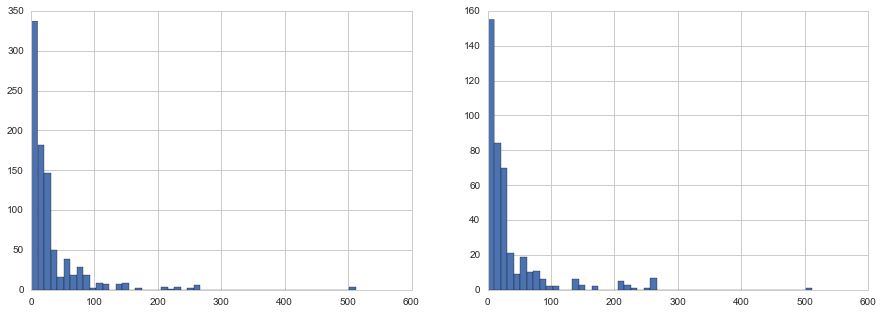

In [9]:
# Fare
# 处理：由于缺失值很少，直接填充均值
print('train dataset null value num:', train_df['Fare'].isnull().sum()) # output: 0
print('test dataset null value num:', test_df['Fare'].isnull().sum()) # output: 1

# 填充均值
train_df['Fare'].fillna( train_df['Fare'].mean(), inplace=True )
test_df['Fare'].fillna( test_df['Fare'].mean(), inplace=True )

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
train_df['Fare'].hist(bins=50, ax=ax1)
test_df['Fare'].hist(bins=50, ax=ax2)

In [10]:
# 训练数据
X_train = train_df.drop(['Survived'], axis=1)
y_train = train_df['Survived']

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_test = test_df.drop(['PassengerId'], axis=1)

In [11]:
# random forest
random_forest = RandomForestClassifier(n_estimators=100, max_depth=10)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print(random_forest.score(X_train, y_train))
# print(random_forest.score(X_test, y_test))

0.94051627385


In [12]:
# Logistic Regression
# logistic_regression = LogisticRegression()
# logistic_regression.fit(X_train, y_train)
# # y_pred = logistic_regression.predict(X_test)
# print(logistic_regression.score(X_train, y_train))
# print(logistic_regression.score(X_test, y_test))

In [13]:
# SVM
# svc = SVC()
# svc.fit(X_train, y_train)
# # y_pred = svc.predict(X_test)
# print(svc.score(X_train, y_train))
# print(svc.score(X_test, y_test))

In [14]:
result = pd.DataFrame({
        'PassengerId': test_df['PassengerId'],
        'Survived': y_pred,
    }
)
result.to_csv('./data/result.csv', index=False)